# Annual Mean Temperature Distribution
This looks at how amplitude and phase of annual mean seasonal cycle change with warming.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [35]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'ps', 'ucomp', 'vcomp', 'drag_q', 'w_atm']  
# Load dataset
tau_lw = [1, 2]
n_exp = len(tau_lw)

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['base', 'k=2']

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
p_surface = float(ds_base[0].pfull[-1])*100

 50%|█████     | 1/2 [00:01<00:01,  1.57s/it]

Removing height from var_keep


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


In [36]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [37]:
ds = []
for i in tqdm(range(n_exp)):
    ds_use = ds_base[i].isel(pfull=-1).load()
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, p_surface)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use = annual_mean(ds_use).mean(dim='lon')    
    ds += [ds_use.assign_coords(time=(ds_use.time - ds_use.time.min()).astype(int))]

100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


In [38]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds[0].lat.size
n_time = ds[0].time.size

def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*(x_anom_squared - np.mean(x_anom_squared))

def quartic_func(x_var, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var-np.mean(x_var))**3
    x_anom_fourth_power = (x_var-np.mean(x_var))**4
    return square_func(x_var, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

def linear_func_shift(time, a, b, c, c_phase, spline):
    x_var = spline(time)
    x_var_shift = spline(time-c_phase)
    return a + b*x_var + c*x_var_shift

def square_func_shift(time, a, b, c, c_phase, d, spline):
    x_var = spline(time)
    x_var_shift = spline(time-c_phase)
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*x_var_shift + d*(x_anom_squared - np.mean(x_anom_squared))

def get_anom(var, ax_time=-1):
    try:
        return var - var.mean(dim='time')
    except TypeError:
        return var - np.mean(var, axis=ax_time, keepdims=True)

## Obtaining Estimate of Amplitude and Phase of Actual Temperature Profile
Below, I smooth the temperature profile with a window of 20 days, and take the phase and amplitude of extrema from the resultant smoothed profile. These are indicated by the grey vertical lines, and differ slightly from the actual maxima and minima shown by the black solid lines.

I record the phase, as indicated by $\delta$, relative to the 1st harmonic of the insolation (shown by thick grey lines on left).

Below the example for a specific latitude, I plot the phase, $\delta$, and amplitude, $|T|$ for all latitudes. These are the values which we want to replicate, with a theoretical value.

In [39]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key))) for key in ['1', '2']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1', '2']}
for i in range(n_lat):
    for key in sw_amp_coefs:
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds[0].time, ds[0].swdn_sfc[:, i], n_time, int(key))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds[0].time, n_time, sw_amp_coefs[key][i], np.zeros(int(key)))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds[0].time[0]), 'max': int(ds[0].time[int(ds[0].time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for j in range(n_exp):
    for i in range(n_lat):
        for key in time_extrema_temp:
            extrema_time_use, spline_use = \
                get_var_extrema_date(ds[j].time, get_anom(ds[j].t_surf[:, i]), smooth_window=smooth_ndays_temp_extrema, type=key, max_extrema=1)
            time_extrema_temp[key]['simulated'][j, i] = extrema_time_use[0]
            amp_extrema_temp[key]['simulated'][j, i] = np.abs(spline_use(time_extrema_temp[key]['simulated'][j, i]))

In [40]:
# General plotting info

plot_lat_ind = -1
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds[0].time[0]-1, ds[0].time[-1]+1]
ax_lims_lat = [np.floor(ds[0].lat[0]), 90]
color_exp = [default_colors[0], default_colors[1]]
label_exp = [f'$\kappa={tau_lw[i]}$' for i in range(n_exp)]
linestyle_harmonic = ['-.', '--']      # first is for 1 harmonic, 2nd is for 2 harmonics
linestyle_approx = {'simulated': '-', 'linear': '--', 'square': ':', '1_harmonic': '-.', 'quartic': '-.'}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx: np.max(np.abs(x - x_approx), axis=1), 
                   'median': lambda x, x_approx: np.median(np.abs(x - x_approx), axis=1), 
                   'mean': lambda x, x_approx: np.mean(np.abs(x - x_approx), axis=1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

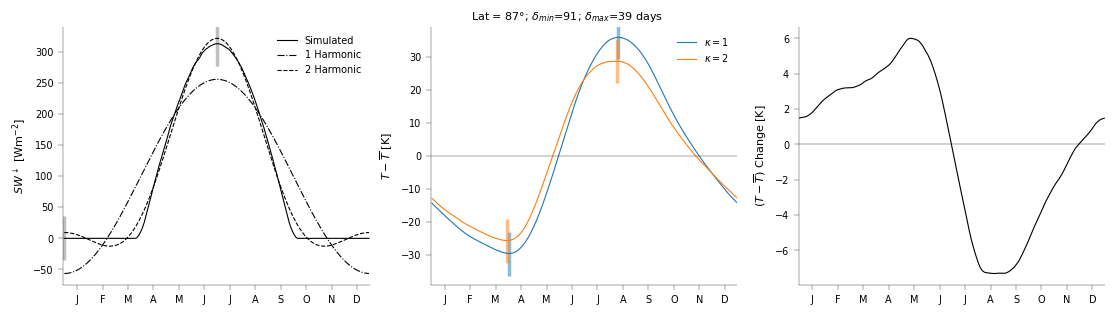

In [41]:
fig_sw_temp_sl, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds[0].time, ds[0].swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')
ax[0].plot(ds[0].time, sw_fourier_fit['1'][plot_lat_ind], color='k', label='1 Harmonic', linestyle=linestyle_harmonic[0])
ax[0].plot(ds[0].time, sw_fourier_fit['2'][plot_lat_ind], color='k', label='2 Harmonic', linestyle=linestyle_harmonic[1])

for i in range(n_exp):
    ax[1].plot(ds[i].time, smooth_func(get_anom(ds[i].t_surf[:, plot_lat_ind])), color=color_exp[i], label=label_exp[i])
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds[0].swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    for i in range(n_exp):
        ax[1].scatter(time_extrema_temp[key]['simulated'][i, plot_lat_ind], 
                      (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][i, plot_lat_ind],
                           color=color_exp[i], marker='|', s=1000, lw=2.5, alpha=0.5)
ax[2].plot(ds[0].time, smooth_func(get_anom(ds[1].t_surf[:, plot_lat_ind])) - smooth_func(get_anom(ds[0].t_surf[:, plot_lat_ind])), 
           color='k', label='Simulated')
ax[2].axhline(0, color='k', lw=ax_linewidth)
ax[2].set_ylabel('$(T - \overline{T})$ Change [K]')
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
ax[1].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${int(ds[0].lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={time_extrema_temp['min']['simulated'][0, plot_lat_ind]-time_extrema_sw['min']:.2g}; "
             f"$\delta_{'{max}'}$={time_extrema_temp['max']['simulated'][0, plot_lat_ind]-time_extrema_sw['max']:.2g} days", fontsize=8, y=0.93);

Text(0.5, 0.05, 'Latitude [deg]')

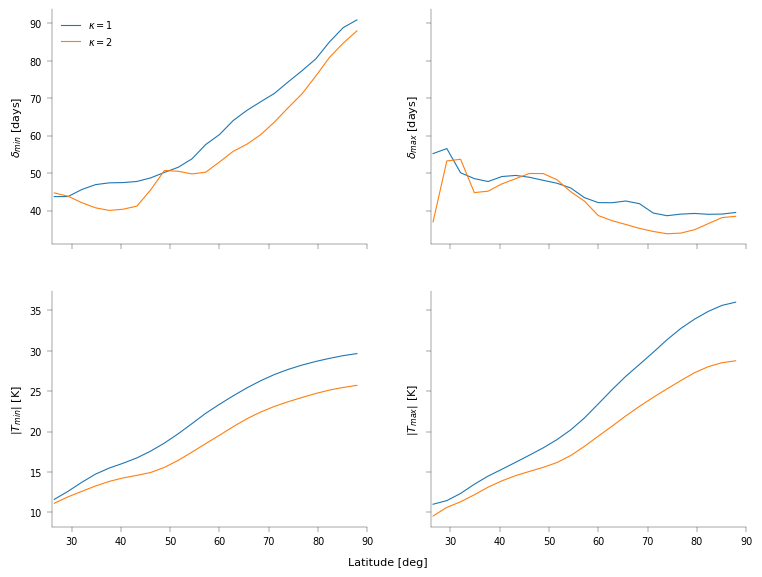

In [42]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for j in range(n_exp):
    for i, key in enumerate(time_extrema_temp):
        ax[0, i].plot(ds[0].lat, time_extrema_temp[key]['simulated'][j] - time_extrema_sw[key], color=color_exp[j], label=label_exp[j])
        ax[1, i].plot(ds[0].lat, amp_extrema_temp[key]['simulated'][j], color=color_exp[j])
        ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
        ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend()
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05)

## Analytic Solution
### Fitting $\Gamma$
The surface energy budget is $C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$.

Below, we fit a linear and square approximation for $\Gamma^{\uparrow}(t) = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow}$
i.e. $\Gamma^{\uparrow} \approx \lambda_0 + \lambda T(t) +\lambda_{sq} (T'^2 - \overline{T'^2})$

With this form of $\Gamma$ and a Fourier representation of $SW^{\downarrow}$, we can get an analytic fourier solution for $T(t)$.

In [43]:
gamma_up = np.zeros((n_exp, n_lat, n_time))
gamma_params = {'linear': np.zeros((n_exp, n_lat, 2)), 'square': np.zeros((n_exp, n_lat, 3)), 
                'linear_shift': np.zeros((n_exp, n_lat, 4)), 'square_shift': np.zeros((n_exp, n_lat, 5))}
gamma_approx = {key: np.zeros((n_exp, n_lat, n_time)) for key in gamma_params}
gamma_params0 = [-800, 4]
for i in range(n_exp):
    gamma_up[i] = np.asarray(ds[i].lwup_sfc - ds[i].lwdn_sfc + ds[i].flux_lhe + ds[i].flux_t).transpose()
    for j in range(n_lat):
        gamma_params['linear'][i, j] = optimize.curve_fit(linear_func, ds[i].t_surf[:, j].to_numpy(), gamma_up[i, j], p0=gamma_params0)[0]
        gamma_params['square'][i, j] = optimize.curve_fit(square_func, ds[i].t_surf[:, j].to_numpy(), gamma_up[i, j], p0=gamma_params0+[0])[0]
        gamma_approx['linear'][i, j] = linear_func(ds[i].t_surf[:, j].to_numpy(), *gamma_params['linear'][i, j])
        gamma_approx['square'][i, j] = square_func(ds[i].t_surf[:, j].to_numpy(), *gamma_params['square'][i, j])
        
        spline_use = scipy.interpolate.CubicSpline(np.append(ds[i].time.to_numpy(), ds[i].time[-1]+1), 
                                                       np.append(ds[i].t_surf[:, j], ds[i].t_surf[0, j]), bc_type='periodic')
        fit_func_use = lambda x, a, b, c, c_phase: linear_func_shift(x, a, b, c, c_phase, spline=spline_use)
        gamma_params['linear_shift'][i, j] = optimize.curve_fit(fit_func_use, ds[i].time, gamma_up[i, j], p0=gamma_params0+[0, 0], 
                                                                bounds=((-np.inf, 0, 0, 0), (np.inf, 8, 8, 20)))[0]
        fit_func_use = lambda x, a, b, c, c_phase, d: square_func_shift(x, a, b, c, c_phase, d, spline=spline_use)
        gamma_params['square_shift'][i, j] = optimize.curve_fit(fit_func_use, ds[i].time, gamma_up[i, j], p0=gamma_params0+[0, 0, 0], 
                                                                bounds=((-np.inf, 0, 0, 0, 0), (np.inf, 8, 8, 20, 0.1)))[0]

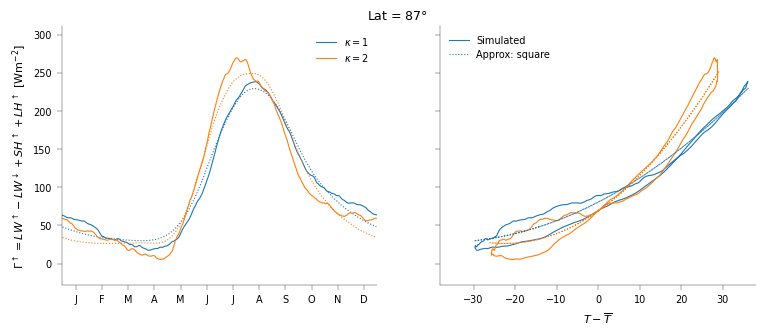

In [60]:
# plot_approx = 'linear'
plot_approx = 'square'
fig, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
for i in range(n_exp):
    ax[0].plot(ds[i].time, smooth_func(gamma_up[i, plot_lat_ind]), color=color_exp[i], label=label_exp[i])
    ax[0].plot(ds[i].time, smooth_func(gamma_approx[plot_approx][i, plot_lat_ind]), color=color_exp[i],
               linestyle=linestyle_approx[plot_approx])
    ax[1].plot(smooth_func(get_anom(ds[i].t_surf[:, plot_lat_ind])), smooth_func(gamma_up[i, plot_lat_ind]), color=color_exp[i],
               label='Simulated' if i==0 else None)
    
func_use = square_func if plot_approx.lower()=='square' else linear_func
for i in range(n_exp):
    ax[1].plot(get_anom(ds[i].t_surf[:, plot_lat_ind]), 
               func_use(ds[i].t_surf[:, plot_lat_ind], *gamma_params[plot_approx][i, plot_lat_ind]), 
               color=color_exp[i], linestyle=linestyle_approx[plot_approx], label=f"Approx: {plot_approx}" if i==0 else None)
    
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(get_anom(ds[0].t_surf[:, plot_lat_ind]).max())+1), 
               np.ceil(np.abs(get_anom(ds[0].t_surf[:, plot_lat_ind]).max())+1))
ax[1].set_ylim(np.floor(gamma_up[:, plot_lat_ind].min()), np.ceil(gamma_up[:, plot_lat_ind].max()))
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig.suptitle(f"Lat = ${int(ds[0].lat[plot_lat_ind])}\degree$", fontsize=9, y=0.93);

### Error of Analytic Solution
Below, we plot the error in the approximation of $\Gamma$ and the resultant analytic solution for $T(t)$. We also plot the error in the change 
with warming between simulations.

In [45]:
day_seconds = 86400
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
def get_x_from_lambda(lambda_const, heat_capacity=heat_capacity, f=1/360, day_seconds=day_seconds):
    return 2*np.pi*f/day_seconds*heat_capacity/lambda_const

temp_approx = {key: np.zeros((n_exp, n_lat, n_time)) for key in ['1_harmonic', 'linear', 'square']}
for i in range(n_exp):
    for j in range(n_lat):
        temp_approx['1_harmonic'][i, j] = get_temp_fourier(ds[i].time, sw_fourier_fit['1'][j], heat_capacity, 
                                                           gamma_params['linear'][i, j], n_harmonics=1)[0]
        temp_approx['linear'][i, j] = get_temp_fourier(ds[i].time, sw_fourier_fit['2'][j], heat_capacity, 
                                                       gamma_params['linear'][i, j])[0]
        temp_approx['square'][i, j] = get_temp_fourier(ds[i].time, sw_fourier_fit['2'][j], heat_capacity, 
                                                       gamma_params['square'][i, j, :-1], 
                                                       lambda_nl=gamma_params['square'][i, j, -1], single_harmonic_nl=True)[0]

for key in temp_approx:
    if '1_harmonic' in key:
        # Use analytical solution for 1 harmonic so as to make value a float, more accurate
        time_extrema_temp['min'][key] = np.arctan(get_x_from_lambda(gamma_params['linear'][:, :, 1], heat_capacity))/(2*np.pi)*360
        time_extrema_temp['max'][key] = time_extrema_temp['min'][key]+360/2
        amp_extrema_temp['min'][key] = np.abs(sw_amp_coefs['1'][:, 1]/gamma_params['linear'][:, :, 1]/np.sqrt(
            1+get_x_from_lambda(gamma_params['linear'][:, :, 1], heat_capacity)**2))
        amp_extrema_temp['max'][key] = amp_extrema_temp['min'][key]
    else:
        time_extrema_temp['min'][key] = np.zeros((n_exp, n_lat))
        time_extrema_temp['max'][key] = np.zeros((n_exp, n_lat))
        amp_extrema_temp['min'][key] = np.zeros((n_exp, n_lat))
        amp_extrema_temp['max'][key] = np.zeros((n_exp, n_lat))
        for i in range(n_exp):
            time_extrema_temp['min'][key][i] = ds[i].time[temp_approx[key][i].argmin(axis=1)].to_numpy()
            time_extrema_temp['max'][key][i] = ds[i].time[temp_approx[key][i].argmax(axis=1)].to_numpy()
            amp_extrema_temp['min'][key][i] = temp_approx[key][i].mean(axis=1) - temp_approx[key][i].min(axis=1)
            amp_extrema_temp['max'][key][i] = temp_approx[key][i].max(axis=1) - temp_approx[key][i].mean(axis=1)

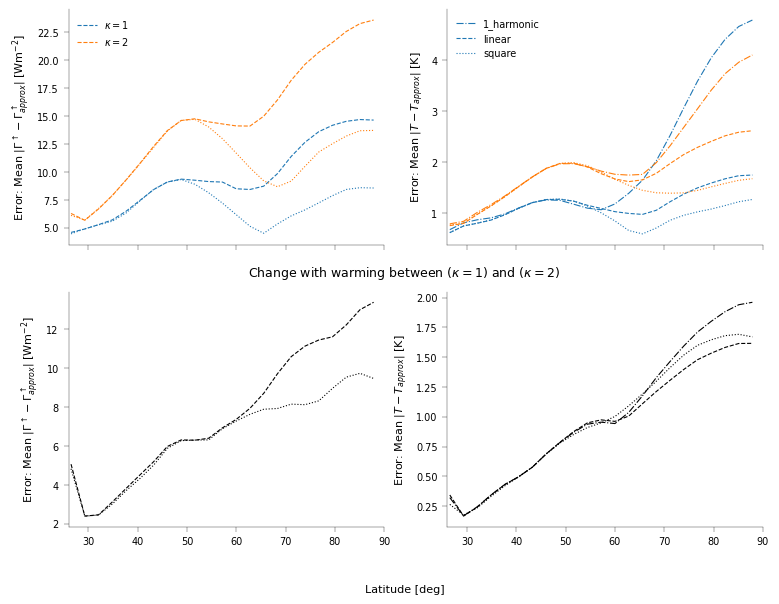

In [46]:
fig_error, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
for key in ['1_harmonic', 'linear', 'square']:
    for i in range(n_exp):
        if key != '1_harmonic':
            ax[0, 0].plot(ds[i].lat, error_func(smooth_func(gamma_up[i]), gamma_approx[key][i]), color=color_exp[i],
                       label=label_exp[i] if key=='linear' else None, linestyle=linestyle_approx[key])
        ax[0, 1].plot(ds[i].lat, error_func(smooth_func(get_anom(ds[i].t_surf.transpose())), get_anom(temp_approx[key][i])), 
                                      color=color_exp[i], linestyle=linestyle_approx[key], label=key if i==0 else None)
    if key != '1_harmonic':
        ax[1, 0].plot(ds[0].lat, error_func(smooth_func(gamma_up[1]) - smooth_func(gamma_up[0]), 
                                            gamma_approx[key][1] - gamma_approx[key][0]), color='k', linestyle=linestyle_approx[key])
    ax[1, 1].plot(ds[0].lat, error_func(smooth_func(get_anom(ds[1].t_surf.transpose())) - smooth_func(get_anom(ds[0].t_surf.transpose())), 
                                        smooth_func(get_anom(temp_approx[key][1])) - smooth_func(get_anom(temp_approx[key][0]))),
                  color='k', linestyle=linestyle_approx[key])
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[0, 1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[1, 0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1, 1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0, 0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8)
fig_error.suptitle(f'Change with warming between $(\kappa={tau_lw[0]})$ and $(\kappa={tau_lw[1]})$', fontsize=9, y=0.5);

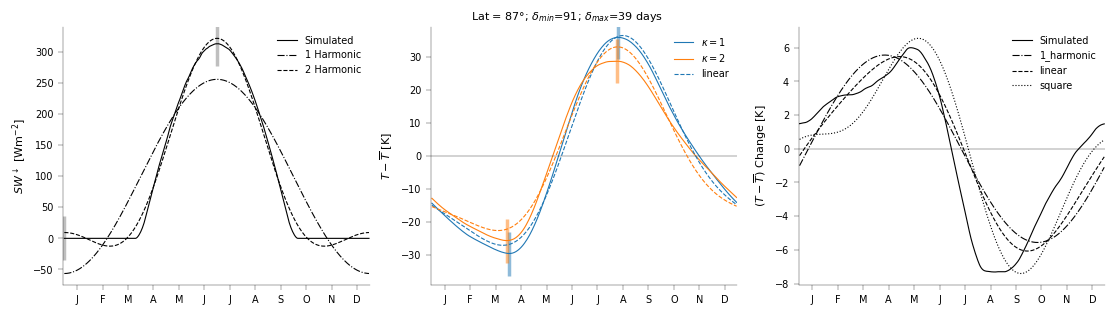

In [47]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
plot_approx = 'linear'
for i in range(n_exp):
    ax[1].plot(ds[i].time, get_anom(temp_approx[plot_approx][i, plot_lat_ind]), color=color_exp[i], 
                          linestyle=linestyle_approx[plot_approx], label=plot_approx if i==0 else None)
ax[1].legend()

for key2 in ['1_harmonic', 'linear', 'square']:
    ax[2].plot(ds[0].time, get_anom(temp_approx[key2][1, plot_lat_ind])-get_anom(temp_approx[key2][0, plot_lat_ind]), color='k', 
                          linestyle=linestyle_approx[key2], label=key2)
ax[2].legend()
fig

### Extrema Phase and Amplitude
Below, we plot the phase and amplitude of the seasonal cycle as predicted by the analytic solutions.

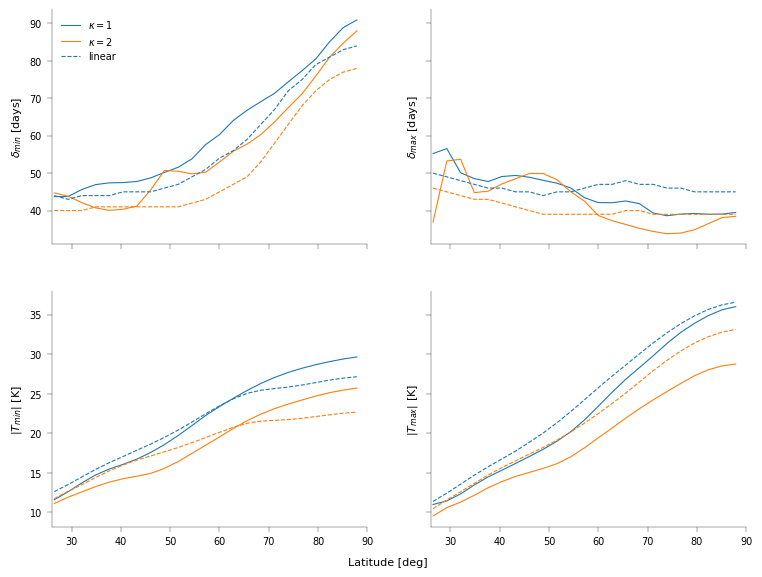

In [48]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
plot_approx = 'linear'
for i in range(n_exp):
    for j, key in enumerate(time_extrema_temp):
        ax[0, j].plot(ds[i].lat, time_extrema_temp[key][plot_approx][i] - time_extrema_sw[key], color=color_exp[i], 
                      linestyle=linestyle_approx[plot_approx], label=plot_approx if i==0 else None)
        ax[1, j].plot(ds[i].lat, amp_extrema_temp[key][plot_approx][i], color=color_exp[i], 
                      linestyle=linestyle_approx[plot_approx])
ax[0, 0].legend()
fig

Text(0.5, 0.05, 'Latitude [deg]')

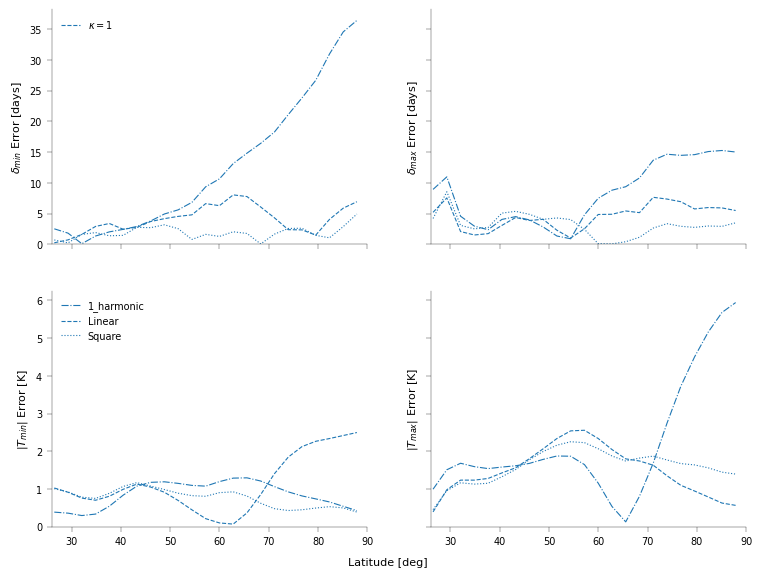

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for j in range(n_exp-1):
    for i, key in enumerate(time_extrema_temp):
        for key2 in ['1_harmonic', 'linear', 'square']:
            ax[0, i].plot(ds[0].lat, np.abs(time_extrema_temp[key]['simulated'][j] - time_extrema_temp[key][key2][j]), 
                          color=color_exp[j], label=label_exp[j] if key2=='linear' else None, linestyle=linestyle_approx[key2])
            ax[1, i].plot(ds[0].lat, np.abs(amp_extrema_temp[key]['simulated'][j] - amp_extrema_temp[key][key2][j]), 
                          color=color_exp[j], label=key2.capitalize() if j==0 else None, linestyle=linestyle_approx[key2])
        ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ Error [days]")
        ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ Error [K]")
for ax_use in ax.flatten():
    ax_use.set_ylim(0, ax_use.get_ylim()[1])
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend(loc='upper left')
ax[1, 0].legend(loc='upper left')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)

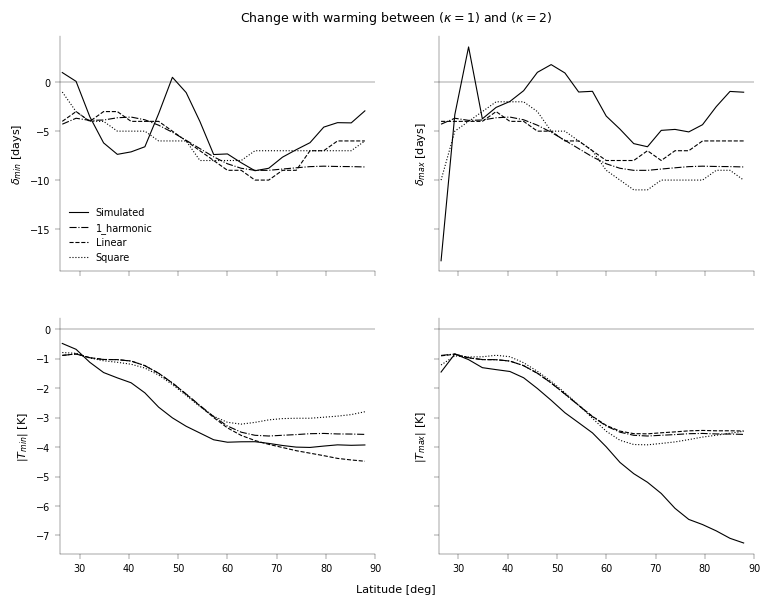

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for key2 in ['simulated', '1_harmonic', 'linear', 'square']:
    for i, key in enumerate(time_extrema_temp):
        ax[0, i].plot(ds[0].lat, time_extrema_temp[key][key2][1] - time_extrema_temp[key][key2][0], color='k', 
                      label=key2.capitalize(), linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds[0].lat, amp_extrema_temp[key][key2][1] - amp_extrema_temp[key][key2][0], color='k', 
                      linestyle=linestyle_approx[key2])
        ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
        ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend()
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
fig.suptitle(f'Change with warming between $(\kappa={tau_lw[0]})$ and $(\kappa={tau_lw[1]})$', fontsize=9, y=0.92);

### Extrema with respect to 1 Harmonic Linear Solution
Below we plot the phase and amplitude with respect to the first harmonic case:

If we write $t_{max} = t_{max1} + \Delta$ and $|T_{max}| = A|T_{max1}|$, where $2 \pi ft_{max1} = \arctan(\frac{2\pi fC}{\lambda})$ and $T_{max1} = \frac{F_1}{\lambda \sqrt{1+(\frac{2\pi fC}{\lambda})^2}}$ are the timings and amplitude of the 1st harmonic, then both $\Delta$ and $A$ only depend on $C/\lambda$ and $F_2/F_1$ in the linear case. 

Text(0.5, 0.05, 'Latitude [deg]')

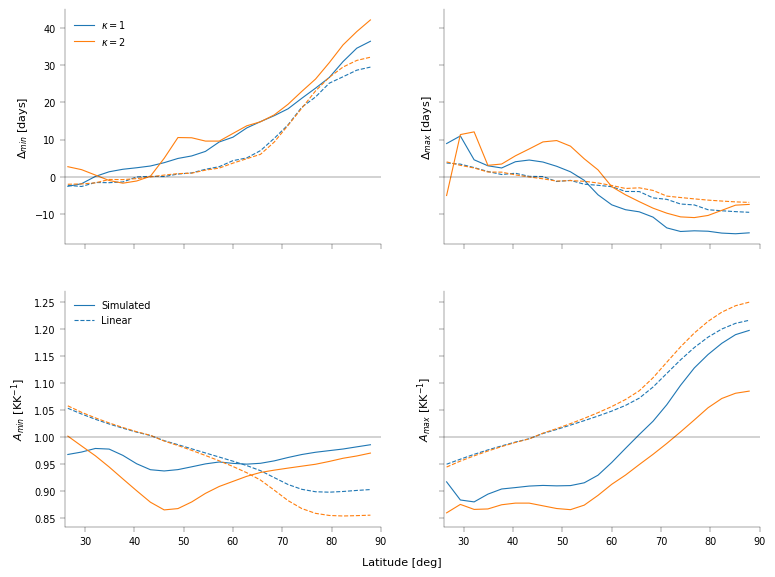

In [51]:
plot_approx = 'linear'
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for j in range(n_exp):
    for i, key in enumerate(time_extrema_temp):
        for key2 in ['simulated', plot_approx]:
            ax[0, i].plot(ds[0].lat, time_extrema_temp[key][key2][j] - time_extrema_temp[key]['1_harmonic'][j], 
                          color=color_exp[j], linestyle=linestyle_approx[key2], label=label_exp[j] if key2=='simulated' else None)
            ax[1, i].plot(ds[0].lat, amp_extrema_temp[key][key2][j] / amp_extrema_temp[key]['1_harmonic'][j], color=color_exp[j],
                          linestyle=linestyle_approx[key2], label=key2.capitalize() if j==0 else None)
        ax[0, i].set_ylabel(f"$\Delta_{'{'+key+'}'}$ [days]")
        ax[1, i].set_ylabel(f"$A_{'{'+key+'}'}$"+" [KK$^{-1}$]")
ax[0, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 0].axhline(1, color='k', lw=ax_linewidth)
ax[1, 1].axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend(loc='upper left')
ax[1, 0].legend(loc='upper left')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)

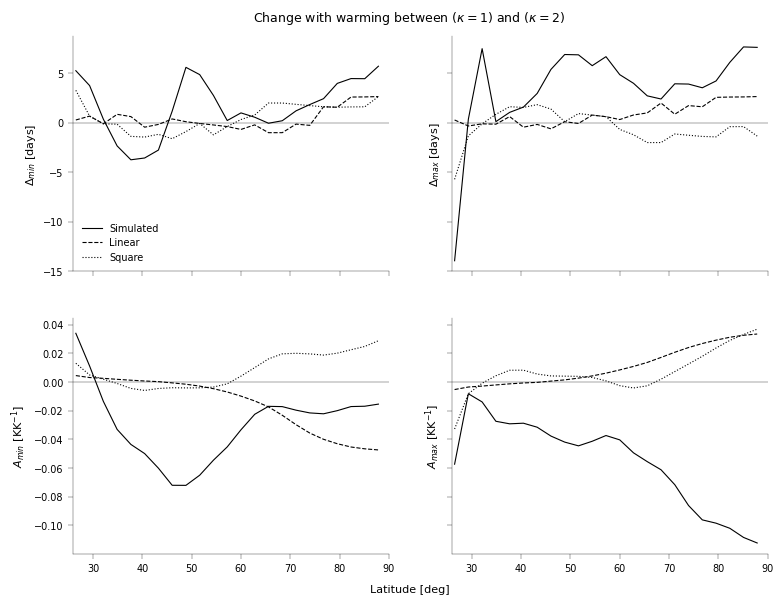

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for key2 in ['simulated', 'linear', 'square']:
    for i, key in enumerate(time_extrema_temp):
        ax[0, i].plot(ds[0].lat, (time_extrema_temp[key][key2][1]-time_extrema_temp[key]['1_harmonic'][1]) -
                      (time_extrema_temp[key][key2][0] - time_extrema_temp[key]['1_harmonic'][0]), color='k', 
                      label=key2.capitalize(), linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds[0].lat, (amp_extrema_temp[key][key2][1] / amp_extrema_temp[key]['1_harmonic'][1]) -
                      (amp_extrema_temp[key][key2][0] / amp_extrema_temp[key]['1_harmonic'][0]), color='k', 
                      label=key2.capitalize(), linestyle=linestyle_approx[key2])
        ax[0, i].set_ylabel(f"$\Delta_{'{'+key+'}'}$ [days]")
        ax[1, i].set_ylabel(f"$A_{'{'+key+'}'}$"+" [KK$^{-1}$]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend()
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
fig.suptitle(f'Change with warming between $(\kappa={tau_lw[0]})$ and $(\kappa={tau_lw[1]})$', fontsize=9, y=0.92);

### Amplitude Issue at High Latitudes for warmer simulation
Clearly, the change with warming of the amplitude of the hottest day of the year is not being captured at high latitudes by the approximation. This is due to latent heat as shown in the decomposition of $\Gamma$ below.

I think the problem may be resolved by including a phase shift term.

In [53]:
gamma_breakdown = {key2: {key: np.zeros((n_exp, n_lat, n_time)) for key in ['lw', 'lh', 'sh']} 
                          for key2 in ['simulated', 'linear', 'square', 'quartic']}
for i in range(n_exp):
    gamma_breakdown['simulated']['lw'][i] = (ds[i].lwup_sfc - ds[i].lwdn_sfc).transpose()
    gamma_breakdown['simulated']['lh'][i] = ds[i].flux_lhe.transpose()
    gamma_breakdown['simulated']['sh'][i] = ds[i].flux_t.transpose()
    for key in ['lw', 'lh', 'sh']:
        for j in range(n_lat):
            params_use = optimize.curve_fit(linear_func, ds[i].t_surf[:, j].to_numpy(), gamma_breakdown['simulated'][key][i, j],
                                            p0=gamma_params0)[0]
            gamma_breakdown['linear'][key][i, j] = linear_func(ds[i].t_surf[:, j].to_numpy(), *params_use)
            params_use = optimize.curve_fit(square_func, ds[i].t_surf[:, j].to_numpy(), gamma_breakdown['simulated'][key][i, j],
                                            p0=gamma_params0+[0])[0]
            gamma_breakdown['square'][key][i, j] = square_func(ds[i].t_surf[:, j].to_numpy(), *params_use)
            params_use = optimize.curve_fit(quartic_func, ds[i].t_surf[:, j].to_numpy(), gamma_breakdown['simulated'][key][i, j],
                                            p0=gamma_params0+[0, 0, 0])[0]
            gamma_breakdown['quartic'][key][i, j] = quartic_func(ds[i].t_surf[:, j].to_numpy(), *params_use)
# gamma_params0 = [-800, 4]
# for i in range(n_exp):
#     gamma_up[i] = np.asarray(ds[i].lwup_sfc - ds[i].lwdn_sfc + ds[i].flux_lhe + ds[i].flux_t).transpose()
#     for j in range(n_lat):
#         gamma_params['linear'][i, j] = optimize.curve_fit(linear_func, ds[i].t_surf[:, j].to_numpy(), gamma_up[i, j], p0=gamma_params0)[0]
#         gamma_params['square'][i, j] = optimize.curve_fit(square_func, ds[i].t_surf[:, j].to_numpy(), gamma_up[i, j], p0=gamma_params0+[0])[0]
#         gamma_approx['linear'][i, j] = linear_func(ds[i].t_surf[:, j].to_numpy(), *gamma_params['linear'][i, j])
#         gamma_approx['square'][i, j] = square_func(ds[i].t_surf[:, j].to_numpy(), *gamma_params['square'][i, j])

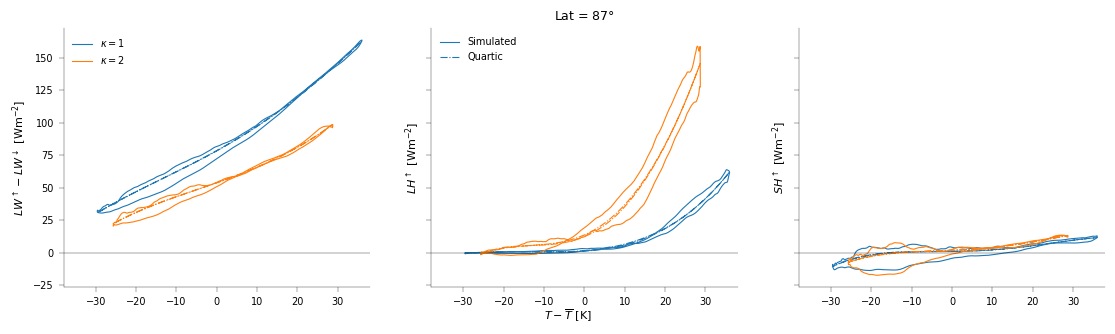

In [64]:
plot_approx = 'quartic'
fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
x_var = [smooth_func(get_anom(ds[i].t_surf[:, plot_lat_ind])) for i in range(n_exp)]
for i in range(n_exp):
    for j, key in enumerate(['lw', 'lh', 'sh']):
        for key2 in ['simulated', plot_approx]:
            if j==0 and key2=='simulated':
                label_use = label_exp[i]
            elif j==1 and i==0:
                label_use = key2.capitalize()
            else:
                label_use = None
            ax[j].plot(x_var[i], smooth_func(gamma_breakdown[key2][key][i, plot_lat_ind]), color=color_exp[i],
                       linestyle=linestyle_approx[key2], label=label_use)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
fig.supxlabel('$T - \overline{T}$ [K]', fontsize=8, y=0)
ax[0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[2].set_ylabel('$SH^{\\uparrow}$ [Wm$^{-2}$]')
ax[0].set_xlim(-np.ceil(np.abs(get_anom(ds[0].t_surf[:, plot_lat_ind]).max())+1), 
               np.ceil(np.abs(get_anom(ds[0].t_surf[:, plot_lat_ind]).max())+1))
ax[0].legend()
ax[1].legend()
ax[1].set_title(f"Lat = ${int(ds[0].lat[plot_lat_ind])}\degree$", fontsize=9);

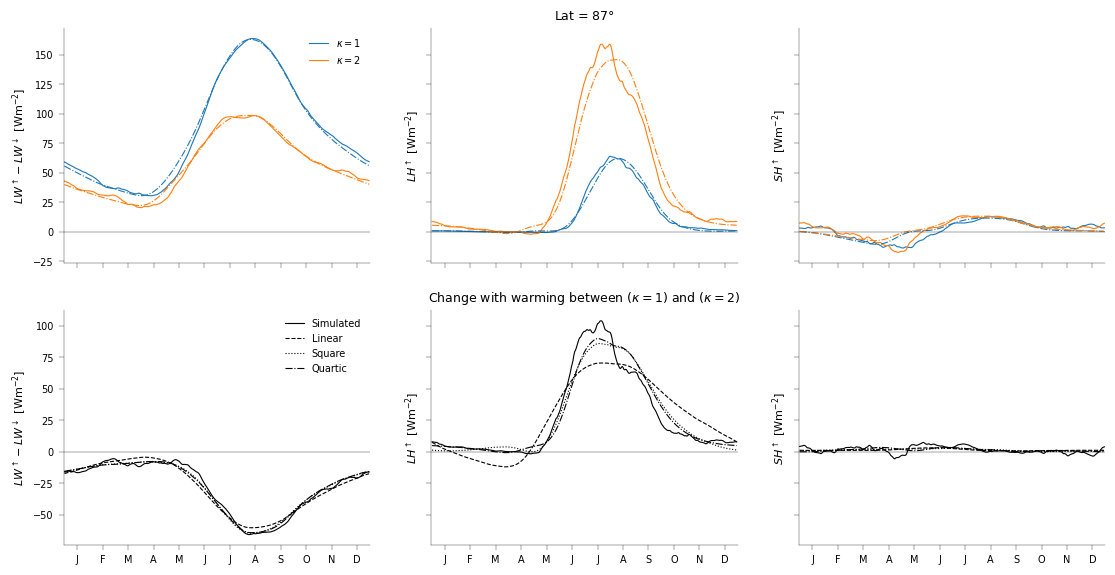

In [63]:
plot_approx = 'quartic'
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for j, key in enumerate(['lw', 'lh', 'sh']):
    for key2 in ['simulated', plot_approx]:
        for i in range(n_exp):
            ax[0, j].plot(ds[i].time, smooth_func(gamma_breakdown[key2][key][i, plot_lat_ind]), color=color_exp[i],
                       linestyle=linestyle_approx[key2], label=label_exp[i] if j==0 and key2=='simulated' else None)
    for key2 in gamma_breakdown:
        ax[1, j].plot(ds[i].time, smooth_func(gamma_breakdown[key2][key][1, plot_lat_ind]) - 
                      smooth_func(gamma_breakdown[key2][key][0, plot_lat_ind]), color='k',
                      linestyle=linestyle_approx[key2], label=key2.capitalize())

for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(-1, 360)
ax[0, 0].set_xticks(*month_ticks)
for i in range(2):
    ax[i, 0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]')
    ax[i, 1].set_ylabel('$LH^{\\uparrow}$ [Wm$^{-2}$]')
    ax[i, 2].set_ylabel('$SH^{\\uparrow}$ [Wm$^{-2}$]')
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].set_title(f"Lat = ${int(ds[0].lat[plot_lat_ind])}\degree$", fontsize=9)
ax[1, 1].set_title(f'Change with warming between $(\kappa={tau_lw[0]})$ and $(\kappa={tau_lw[1]})$', fontsize=9);